In [1]:
import cv2
import time
import imutils 
from collections import deque

import tensorflow as tf
import os
import shutil
import numpy as np
import random
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from pathlib import Path
import re
import cv2
from keras import backend as K
tf.__version__
import glob
import imageio

import skimage.feature
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

#check if tensorflow gpu is being used
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("tensorflow version:", tf.__version__)

Num GPUs Available:  1
tensorflow version: 2.10.0


Single Frame Feature Extraction

In [2]:
#videos to choose from
NeedleViz_path1 = 'Data/edited data/102622_Water.mp4'
NeedleViz_path2 = 'Data/edited data/102822_Water.mp4'
NeedleViz_oilAndLatex = 'Data/edited data/oil and latex/capture_5_2022-11-12T16-56-03.mp4'
NeedleViz_gelAndLatex = 'Data/edited data/ultrasound gel and latex/capture_4_2022-11-12T17-33-19.mp4'
NeedleViz_clarius1 = 'Data/edited data/clarius_FinalPrototype_needlejustWater.mp4'
NeedleViz_clarius2 = 'Data/edited data/clarius_FinalPrototype_needlejustWater2.mp4'
NeedleViz_clarius3 = 'Data/edited data/clarius_FinalPrototype_needleWithSolid.mp4'
NeedleViz_clarius4 = 'Data/edited data/clarius_FinalPrototype_needleWithSolid2.mp4'
NeedleViz_clarius5 = 'Data/edited data/clarius_FinalPrototype_needleWithSolid3.mp4'

In [3]:
frameList = []

vc = cv2.VideoCapture(NeedleViz_clarius1)

if (vc.isOpened()== False): 
  print("Error opening video  file")

while(vc.isOpened()):
    rval, frame = vc.read()
    
    if rval == True:
      frameList.append(frame)
        
    #Break out of loop if video is done
    else:
        break  

vc.release() #Release the video capture object

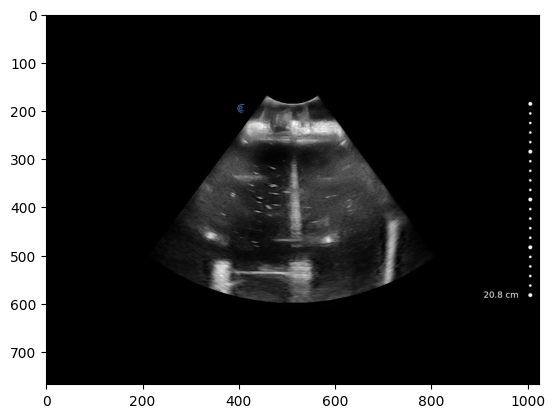

In [35]:
image = frameList[1]
image_refined = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
plt.imshow(image)

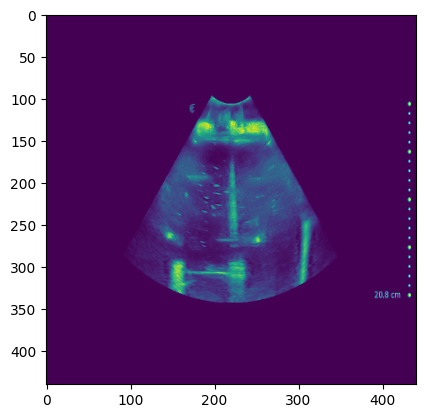

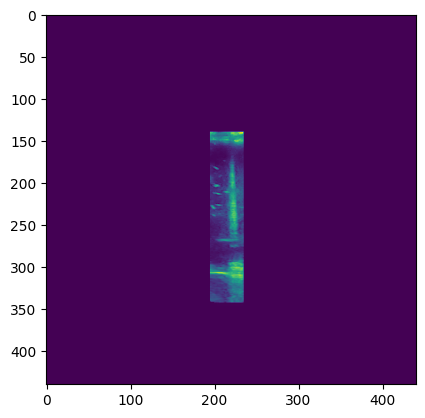

In [36]:
### ROI FRAME EXTRACTION ###

size = (440, 440)

#Initial Frame preprocessing
resized_frame = cv2.resize(image, size)
resized_frame = cv2.cvtColor(resized_frame, cv2.COLOR_RGB2GRAY)

plt.figure()
plt.imshow(resized_frame)

#Achieving desired region of interest within Raw Frame
row_start = 140 #previously 94
row_end = 348
col_start = 195 #previously 166
col_end = 235 #previously 275

ROI_frame = resized_frame[row_start:row_end, col_start:col_end] #old one was [94:348, 166:275]
ROI_image = np.zeros_like(resized_frame)
x = row_start 
y = col_start 
for i in range(0, row_end-row_start):
    for j in range(0, col_end-col_start):
        if ROI_frame[i][j] != 0:
            ROI_image[x + i, y + j] = ROI_frame[i, j]

plt.figure()
plt.imshow(ROI_image)

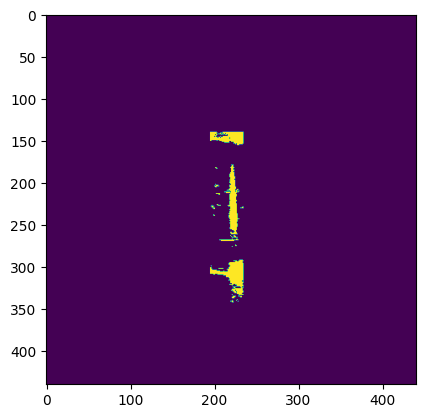

In [37]:
### BLURRING AND THRESHOLDING ###

thresh = cv2.threshold(ROI_image, 90, 255, cv2.THRESH_BINARY)[1]
plt.figure()
plt.imshow(thresh)

# adapt_thresh = cv2.adaptiveThreshold(thresh, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 21, 10)

# plt.figure()
# plt.imshow(adapt_thresh)

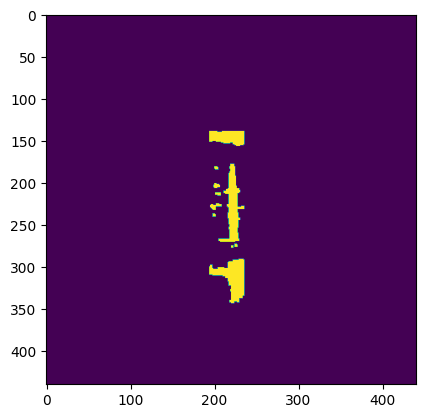

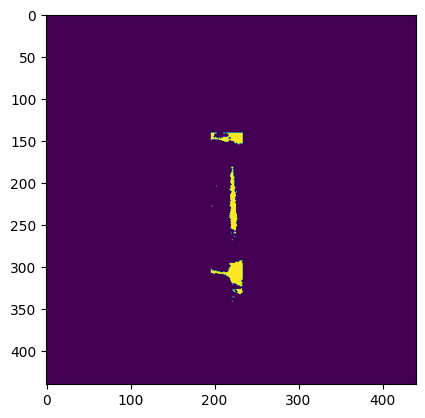

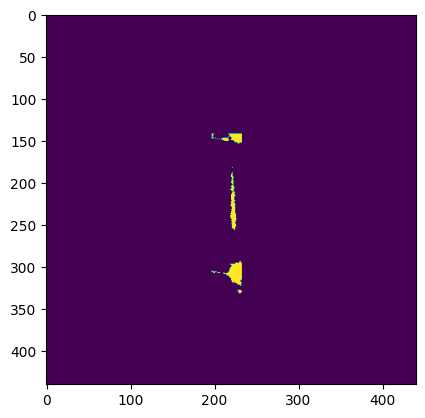

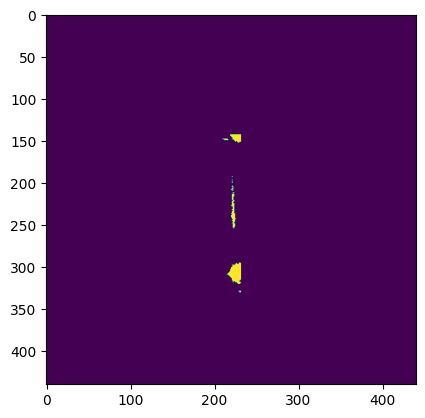

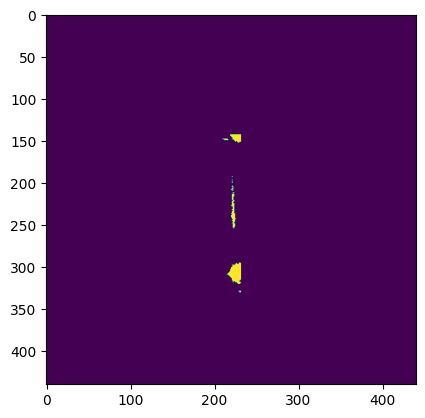

In [38]:
### MORPHOLOGICAL OPERATIONS ###
dilate = cv2.dilate(thresh, None, iterations=2)
erode = cv2.erode(dilate, None, iterations=2)
dilate_2 = cv2.dilate(erode, None, iterations=1)

plt.figure()
plt.imshow(dilate_2)

#Creating skeleton -> https://medium.com/analytics-vidhya/skeletonization-in-python-using-opencv-b7fa16867331 

skel_image = thresh.copy()

# Step 1: Create an empty skeleton
size = np.size(skel_image)
skel = np.zeros(skel_image.shape, np.uint8)

# Get a Cross Shaped Kernel
element = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))

count = 0
# Repeat steps 2-4
while True:
    #Step 2: Open the image
    open = cv2.morphologyEx(skel_image, cv2.MORPH_OPEN, element)
    #Step 3: Substract open from the original image
    temp = cv2.subtract(skel_image, open)
    #Step 4: Erode the original image and refine the skeleton
    eroded = cv2.erode(skel_image, element)
    skel = cv2.bitwise_or(skel_image,temp)
    skel_image = eroded.copy()

    plt.figure()
    plt.imshow(skel_image)
    count += 1
    # Step 5: If there are no white pixels left ie.. the image has been completely eroded, quit the loop
    if count == 3:
        break

plt.figure()
plt.imshow(skel_image)

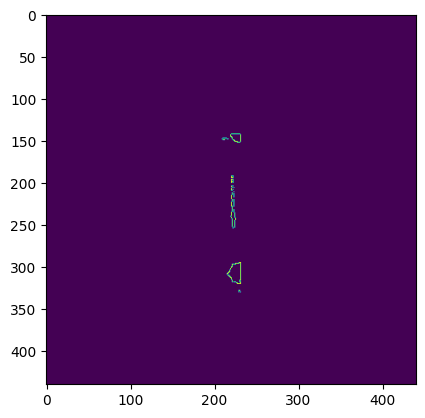

In [39]:
### CANNY EDGE DETECTION ###
canny = cv2.Canny(skel_image, 73,200)

plt.imshow(canny)

In [40]:
bbox = resized_frame.copy()
detect_bbox(canny,bbox)
plt.imshow(bbox)

NameError: name 'detect_bbox' is not defined

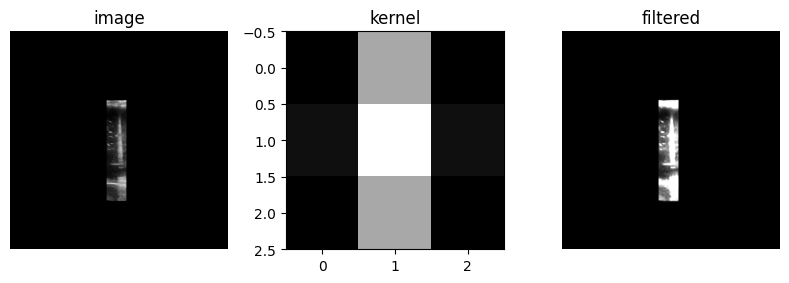

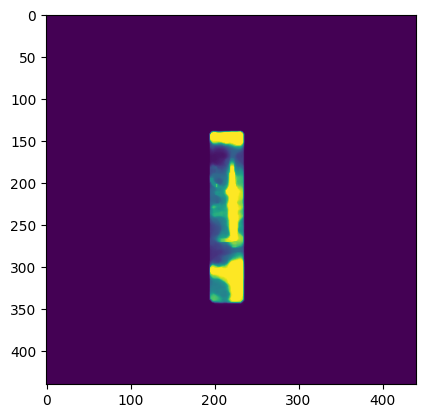

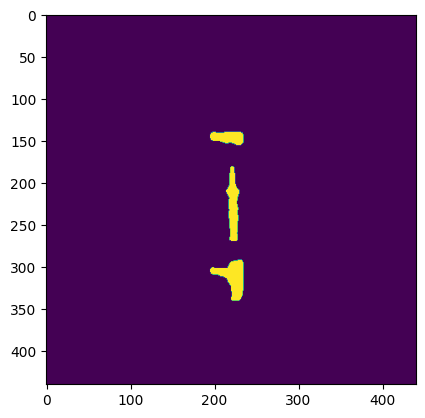

In [41]:
#Algorithm based on Paper: https://ris.utwente.nl/ws/portalfiles/portal/268816902/elk_28_5_37_1912_181.pdf 

#Raw Image
raw_image = ROI_image.copy()
# plt.figure()
# plt.imshow(raw_image)

#Gabor Filter at angle 0

gabor_filter = cv2.getGaborKernel((3,3), sigma=0.95, theta=0, lambd=5, gamma=0.8, psi=0, ktype=cv2.CV_32F)
# gabor_filter = cv2.getGaborKernel((3,3), sigma=10, theta=0, lambd=30, gamma=0.25, psi=0, ktype=cv2.CV_32F)
# plt.figure()
# plt.imshow(gabor_filter)
gabor_output = cv2.filter2D(raw_image, -1, gabor_filter)
# plt.figure()
# plt.imshow(gabor_output)

plt.figure(figsize=(8,3))
plt.subplot(131)
plt.axis('off')
plt.title('image')
plt.imshow(raw_image, cmap='gray')
plt.subplot(132)
plt.title('kernel')
plt.imshow(gabor_filter, cmap='gray')
plt.subplot(133)
plt.axis('off')
plt.title('filtered')
plt.imshow(gabor_output, cmap='gray')
plt.tight_layout()
plt.show()

#Binarized image is divided into grids for needle axis localization.
# - Median filter
median_filter = cv2.medianBlur(gabor_output, 7)
plt.figure()
plt.imshow(median_filter)
# - automatic thresholding
threshold = cv2.threshold(median_filter, 250, 255, cv2.THRESH_BINARY)[1]
# - morphological operations
element = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
eroded = cv2.erode(threshold, element)
dilated = cv2.dilate(eroded, element)
plt.figure()
plt.imshow(dilated)

#needle tip estimation


# Connected components

# largest connected component is chosen as the needle

#  Needle axis is localized by applying RANSAC line fitting to each grid

# The needle tip is estimated using probability mapping method




In [42]:
import math

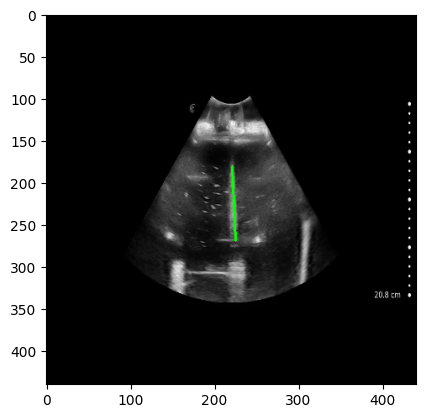

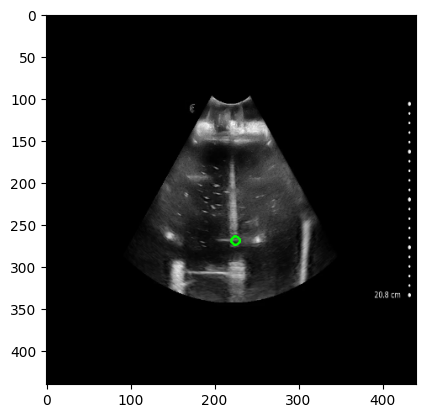

In [43]:
lines = cv2.HoughLinesP(dilated, rho=6, theta=np.pi / 60, threshold=160, lines=np.array([]), minLineLength=40, maxLineGap=4)

overlay_image = cv2.cvtColor(resized_frame, cv2.COLOR_GRAY2RGB)

houghline = overlay_image.copy()
houghcircle = overlay_image.copy()

length_line_list = []

for line in lines:
    # print(line)
    # print(line[0][0])
    # Start coordinate, here (0, 0)
    # represents the top left corner of image
    x1 = line[0][0]
    y1 = line[0][1]
    x2 = line[0][2]
    y2 = line[0][3]

    start_point = (x1, y1)
    
    # End coordinate, here (250, 250)
    # represents the bottom right corner of image
    end_point = (x2, y2)
    
    # Green color in BGR
    color = (0, 255, 0)
    
    # Line thickness of 9 px
    thickness = 2

    #circle radius
    radius = 5

    lengthOfLine = math.sqrt(abs(x2-x1)^2 + abs(y2-y1)^2)
    # print(lengthOfLine)
    length_line_list.append(lengthOfLine)

    # Using cv2.line() method
    # Draw a diagonal green line with thickness of 9 px
    # cv2.line(houghline, start_point, end_point, color, thickness)
    # cv2.circle(houghcircle, end_point, radius, color, thickness)

index_number = length_line_list.index(max(length_line_list))

x1 = lines[index_number][0][0]
y1 = lines[index_number][0][1]
x2 = lines[index_number][0][2]
y2 = lines[index_number][0][3]

start_point = (x1, y1)
end_point = (x2, y2)

# Green color in BGR
color = (0, 255, 0)

# Line thickness of 9 px
thickness = 2

#circle radius
radius = 5

cv2.line(houghline, start_point, end_point, color, thickness)
cv2.circle(houghcircle, end_point, radius, color, thickness)

plt.figure()
plt.imshow(houghline)

plt.figure()
plt.imshow(houghcircle)

